# Обнаружение вредоносных URL и их классификация
### Дисклеймер:
Задачу я решал в два этапа. Первый - отделение "чистых" адресов от вредоносных. Второй - классификация вредоносных адресов. При этом я хотел отказаться от мешка слов, хотя бы на первом этапе.

In [1]:
%matplotlib inline
import ipaddress as ip
import numpy as np
import pandas as pd
import warnings
from scipy.sparse import hstack
warnings.filterwarnings(action="ignore")
from urllib.parse import urlparse
from tldextract import extract
import sklearn.ensemble as ens
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree, linear_model
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import seaborn

Загрузим датасет и проверим его на целостность:

In [2]:
dataset = pd.read_csv("train.csv", encoding='cp1252')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84750 entries, 0 to 84749
Data columns (total 2 columns):
url      84750 non-null object
label    84750 non-null object
dtypes: object(2)
memory usage: 1.3+ MB


Посмотрим на баланс классов:

Safe            76309
Phishing         3823
Malicious        3646
Unsafe click      972
Name: label, dtype: int64


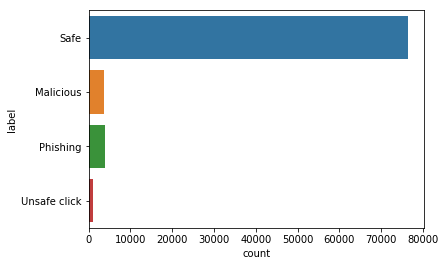

In [3]:
print(dataset.label.value_counts())
seaborn.countplot(y="label", data=dataset);

In [4]:
RANDOM_SEED = 1488

Сначала будем классифицировать URL на опасные и безопасные. Для этого посчитаем столбец **binary-label**:

In [5]:
classes = ["Safe", "Malicious", "Phishing", "Unsafe click"]
bad_classes = ["Malicious", "Phishing", "Unsafe click"]
binary_classes = ["Good", "Bad"]
dataset['binary-label'] = dataset.label.apply(lambda x: "Good" if x == "Safe" else "Bad")

Далее - функции для подсчета признаков:

In [6]:
#Число разделителей
def count_delimiters(string):
    cnt = 0
    delim = ['.', ';','_','?','=','&', '-']
    for c in string:
        if c in delim:
            cnt += 1
    return cnt

Использование IP-адреса вместо доменного имени - признак подозрительного сайта.

In [7]:
#Проверка, является ли строка IP-адресом
def is_ip(string):
    try:
        if ip.ip_address(string):
            return 1
    except ValueError:
        return 0

In [8]:
#Число точек и слешей
def count_dots(string):
    return string.count('.')

def count_slashes(string):
    return string.count('/')

Наличие **\@** и **//** - признак перенаправления на другой сайт. Браузер игнорирует все, что написано до **\@**. Можно проверить, вставив в адресную строку браузера: http://random_text_here@wikipedia.org

In [9]:
def count_double_slashes(string):
    return string.count('//')

def count_At(string):
    return string.count('@')

In [10]:
#Доля букв среди буквенно-цифровых символов
def count_letter_percentage(string):
    s1 = sum(c.isalpha() for c in string)
    s2 = sum(c.isdigit() for c in string)
    return  s1 / (s1 + s2)

#Доля прописных букв среди всех букв
def count_uppercase_percentage(string):
    s1 = sum(c.isalpha() for c in string)
    if s1 == 0:
        return -1
    return sum(c.isupper() for c in string) / s1

Список "хороших" и подозрительных доменов и слов. Их наличие будет одним из признаков. Разумеется, этот список можно увеличивать, но улучшение алгоритма таким способом не было моей целью.

In [11]:
suspicious_domains = ['bit.ly', 'goo.gl', 'tinyurl.com'] #to be continued ...
suspicious_words = ['download', 'pay', 'password', 'store', 'account'] #to be continued
reliable_domains = ['wikipedia.org', 'wikimedia.org', 'github.com', 'twitter.com', 'instagram.com', 'stackoverflow.com'] #to be continued ...

Кстати, одним из признаков подозрительного URL является "маскировка" под известные сайты. Это можно отследить, например, если в адресе есть "twitter", за которым сразу не следует ".com". Реализую это потом, если останется время.

In [12]:
def check_reliable_domain(netloc):
    for dom in reliable_domains:
        if dom in netloc:
            return 1
    return 0

def check_suspicious_domain(netloc):
    for dom in suspicious_domains:
        if dom in netloc:
            return 1
    return 0

def count_suspicious_words(netloc):
    cnt = 0
    for word in suspicious_words:
        if word in netloc:
            cnt += 1
    return cnt

Подсчитываем значения признаков и создаем матрицу. Для работы с адресами используются библиотеки **urllib** и **tldextract**.

In [13]:
def get_url_features(url):
    url1 = url
    if not url.startswith(('http', 'mailto')):
        url1 = "//" + url
    features = [url]
    parsed_url = urlparse(url1)
    ext = extract(parsed_url.netloc)
    
    if parsed_url.scheme != 'mailto':
        features.append(count_At(url))
    else:
        features.append(0)
    
    features.append(len(url))
    
    features.append(count_dots(ext.subdomain))
    
    features.append(count_slashes(parsed_url.path))
    
    features.append(count_double_slashes(parsed_url.path + parsed_url.query))
    
    features.append(count_delimiters(parsed_url.path))
    
    features.append(check_reliable_domain(parsed_url.netloc))
    
    features.append(check_suspicious_domain(parsed_url.netloc))
    
    features.append(count_suspicious_words(parsed_url.netloc))
    
    features.append(len(parsed_url.query))
    
    features.append(count_letter_percentage(url))
    
    features.append(count_uppercase_percentage(url))
    
    features.append(is_ip(parsed_url.netloc))
    
    return features

In [14]:
%%time

flist=[]

for i in range(dataset.shape[0]):
    features = get_url_features(dataset.url.loc[i])
    features.append(binary_classes.index(dataset['binary-label'].loc[i]))
    features.append(classes.index(dataset['label'].loc[i]))
    flist.append(features)

URL_Features = pd.DataFrame(data=flist, columns=["url", "numAt", "len", "numDots", "numSlashes", "numDSlashes", "numDel", 
                                                 "rel", "susp", "susp_words", "len_query", "letter%", "upper%", "ip", "binary-label", "label"])

Wall time: 15.7 s


In [15]:
URL_Features.sample(10)

,url,numAt,len,numDots,numSlashes,numDSlashes,numDel,rel,susp,susp_words,len_query,letter%,upper%,ip,binary-label,label
53261,strategyeye.com,0,15,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
14161,theedgesingapore.com,0,20,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
56764,inglenook.com,0,13,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
56320,http://devapk.com/zyztd/hotm/443813e9f085d2056...,0,230,0,4,0,1,0,0,0,157,0.495327,0.0,0,1,1
50492,cialisspc.com,0,13,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
40217,chhayaconstruction.com,0,22,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
16077,cacaosampaka.com,0,16,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
35846,dsn4u.com,0,9,0,0,0,0,0,0,0,0,0.875000,0.0,0,0,0
82600,nkdesign.ie,0,11,0,0,0,0,0,0,0,0,1.000000,0.0,0,0,0
72133,http://soft2.xitongzhijia.net/201203,0,36,0,1,0,0,0,0,0,0,0.766667,0.0,0,1,1


Разделяем выборку на тестовую и обучающую:

In [16]:
test_size = 0.2

train, test = train_test_split(
    URL_Features,
    test_size=test_size,
    random_state=RANDOM_SEED,
)

In [17]:
X_train = train.drop(['url', 'label', 'binary-label'], axis=1)
X_test = test.drop(['url', 'label', 'binary-label'], axis=1)
y_train = train['binary-label']
y_test = test['binary-label']
y = test['label']

Далее из нескольких алгоритмов выберем выдающий наибольшую целевую метрику *f1-macro*

In [18]:
models = {"DecisionTree":tree.DecisionTreeClassifier(random_state=RANDOM_SEED),
         "RandomForest":ens.RandomForestClassifier(n_estimators=50, random_state=RANDOM_SEED),
         "AdaBoost":ens.AdaBoostClassifier(n_estimators=50),
         "XGBoost":xgb.XGBClassifier(n_estimators=50, learning_rate=0.4),
         "LogisticRegression":LogisticRegression()
}

In [19]:
for model in models:
    clf = models[model]
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print ("%s : %s " %(model, f1_score(y_test, y_pred, average='macro')))

DecisionTree : 0.9447906234974167 
RandomForest : 0.9553299888364504 
AdaBoost : 0.948036193845369 
XGBoost : 0.9541931876894869 
LogisticRegression : 0.9016068690696645 


Лучший результат показывает случайный лес. Попробуем подобрать гиперпараметры модели:

In [20]:
%%time

def score_func(y_true, y_pred, **kwargs):
    return f1_score(y_true, y_pred, average='macro')

grid_params = {
    'max_depth': [10, 20, 30, 40, 50, None],
    'max_features': ['sqrt', None]
}

rf_clf = ens.RandomForestClassifier(
    n_estimators=50,
    random_state=RANDOM_SEED
)

scorer = make_scorer(score_func)

grid_search = GridSearchCV(
    rf_clf, 
    param_grid=grid_params,
    scoring=scorer,
    cv=3,
    verbose=0,
    refit=True,
    return_train_score=True
)

grid_search.fit(X_train, y_train);

Wall time: 1min 7s


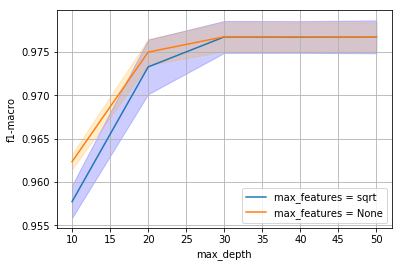

In [21]:
cv_results = grid_search.cv_results_
train_score_sqrt = cv_results['mean_train_score'][:-3: 2]
train_score_None = cv_results['mean_train_score'][1:-2: 2]
std_sqrt = cv_results['std_train_score'][:-3:2]
std_None = cv_results['std_train_score'][1:-2:2]
plt.plot(grid_params['max_depth'][:-1], train_score_sqrt, label='max_features = sqrt')
plt.fill_between(grid_params['max_depth'][:-1], train_score_sqrt + 3 * std_sqrt, train_score_sqrt - 3 * std_sqrt, 
                 alpha=0.2, color='b')
plt.plot(grid_params['max_depth'][:-1], train_score_None, label='max_features = None')
plt.fill_between(grid_params['max_depth'][:-1], train_score_None + 3 * std_None, train_score_None - 3 * std_None, 
                 alpha=0.2, color='orange')
plt.xlabel('max_depth')
plt.ylabel('f1-macro')
plt.legend(loc='best')
plt.grid(True)

Видим, что качество растет по мере увеличения глубины деревьев, и слабо зависит от разбиения. Возьмем наилучшие параметры и применим алгоритм на тестовой выборке.

In [22]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits = 4, target_names=binary_classes))

              precision    recall  f1-score   support

        Good     0.9913    0.9913    0.9913     15258
         Bad     0.9214    0.9220    0.9217      1692

   micro avg     0.9844    0.9844    0.9844     16950
   macro avg     0.9564    0.9566    0.9565     16950
weighted avg     0.9844    0.9844    0.9844     16950



Еще один подхот к разбиению на опасные и безопасные адреса - использование TF-IDF с токенизатором

In [23]:
import re
def makeTokens(string):
    return filter(None, re.split("[./\-&?]", string))

In [24]:
token_vectorizer = TfidfVectorizer(tokenizer=makeTokens).fit(train['url'])
print("n_features:" + str(len(token_vectorizer.get_feature_names())))
X_train_token = token_vectorizer.transform(train['url'])
X_test_token = token_vectorizer.transform(test['url'])

n_features:77843


In [25]:
token_logreg = LogisticRegression().fit(X_train_token, y_train)
logreg_token_predict=token_logreg.predict(X_test_token)
print(classification_report(y_test, logreg_token_predict, digits = 4, target_names=binary_classes))

              precision    recall  f1-score   support

        Good     0.9792    0.9914    0.9853     15258
         Bad     0.9128    0.8103    0.8585      1692

   micro avg     0.9733    0.9733    0.9733     16950
   macro avg     0.9460    0.9008    0.9219     16950
weighted avg     0.9726    0.9733    0.9726     16950



Тоже неплохой результат (в первом приближении), который, вероятно, можно улучшить, изменяя параметры модели. Но использовать его я не буду.  
¯\\_(ツ)_/¯ 

In [26]:
test['pred'] = y_pred

Теперь нужно классифицировать вредоносные URL. Здесь я не нашел ничего лучше, чем анализ n-грамм и целых слов (через FeatureUnion)

In [27]:
mal_train = train[train['binary-label']!=0][["url", "label"]]
mal_test = test[test['pred']!=0][["url", "label", "pred"]]

In [42]:
feature_union = FeatureUnion([("wc", CountVectorizer(
    analyzer="word",
    token_pattern="[A-Za-z]+",
    min_df=0.0001)), ("cc", CountVectorizer(
    analyzer="char",
    ngram_range=(1, 3),
    min_df = 0.001)
)])

In [43]:
final_features = feature_union.fit(mal_train.url)
X_test_final = final_features.transform(mal_test.url)
X_train_final = final_features.transform(mal_train.url)
y_test_final = mal_test.label
y_train_final = mal_train.label

In [44]:
final_models = {"DecisionTree":tree.DecisionTreeClassifier(random_state=RANDOM_SEED),
         "RandomForest":ens.RandomForestClassifier(n_estimators=50, random_state=RANDOM_SEED),
         "AdaBoost":ens.AdaBoostClassifier(n_estimators=50),
         "XGBoost":xgb.XGBClassifier(objective='multi:softmax', learning_rate=0.4, n_estimators=50),
         "LogisticRegression":LogisticRegression()
}

In [45]:
test.reset_index(drop=True, inplace=True)
for model in final_models:
    clf = final_models[model]
    clf.fit(X_train_final,y_train_final)
    y_pred_final_mal = clf.predict(X_test_final)
    y_pred_final = np.zeros(len(test))
    idx = 0
    for i in range(len(test)):
        if test.at[i, 'pred'] == 1:
            y_pred_final[i] = y_pred_final_mal[idx]
            idx += 1
    print ("%s : %s " %(model, f1_score(y, y_pred_final, average='macro')))

DecisionTree : 0.9260909711519442 
RandomForest : 0.9367434157832831 
AdaBoost : 0.8412194331944937 
XGBoost : 0.9407607445853472 
LogisticRegression : 0.9371104110985933 


Подберем параметры модели:

In [46]:
%%time

grid_xgb_params = {
    'learning_rate': np.arange(0.1, 0.55, 0.05)
}

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', n_estimators=50)

grid_search1 = GridSearchCV(
    xgb_clf, 
    param_grid=grid_xgb_params,
    scoring=scorer,
    cv=3,
    verbose=0,
    refit=True,
    return_train_score=True
)

grid_search1.fit(X_train_final, y_train_final);

Wall time: 3min 5s


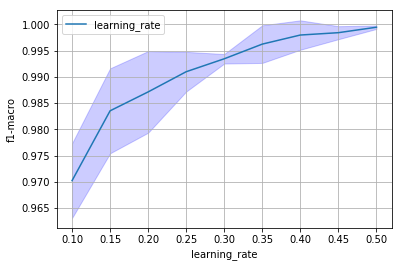

In [47]:
xgb_cv_results = grid_search1.cv_results_
train_score = xgb_cv_results['mean_train_score']
std = xgb_cv_results['std_train_score']
plt.plot(grid_xgb_params['learning_rate'], train_score, label='learning_rate')
plt.fill_between(grid_xgb_params['learning_rate'], train_score + 3 * std, train_score - 3 * std, 
                 alpha=0.2, color='b')
plt.xlabel('learning_rate')
plt.ylabel('f1-macro')
plt.legend(loc='best')
plt.grid(True)

In [48]:
y_pred_final = grid_search1.best_estimator_.predict(X_test_final)

In [49]:
test.reset_index(drop=True, inplace=True)
idx = 0
test['final-label'] = 0
for i in range(len(test)):
    if test.at[i, 'pred'] == 1:
        test.at[i, 'final-label'] = y_pred_final[idx]
        idx += 1


print(classification_report(y, test['final-label'].values, digits=4, target_names=classes))

              precision    recall  f1-score   support

        Safe     0.9913    0.9913    0.9913     15258
   Malicious     0.8514    0.9248    0.8866       731
    Phishing     0.9786    0.8932    0.9340       768
Unsafe click     0.9293    0.9534    0.9412       193

   micro avg     0.9835    0.9835    0.9835     16950
   macro avg     0.9377    0.9407    0.9383     16950
weighted avg     0.9840    0.9835    0.9836     16950



Теперь попробуем объединить мои фичи и "мешок слов":

In [50]:
features = feature_union.fit(train["url"])
train_features = features.transform(train["url"])
test_features = features.transform(test["url"])
X_train_union = hstack((X_train, train_features))
X_test_union = hstack((X_test, test_features))
y_train_union = train.label

In [51]:
for model in final_models:
    clf = final_models[model]
    clf.fit(X_train_union,y_train_union)
    y_pred_union = clf.predict(X_test_union)
    print ("%s : %s " %(model, f1_score(y, y_pred_union, average='macro')))

DecisionTree : 0.9443413332122634 
RandomForest : 0.9630226591073289 
AdaBoost : 0.8218850096998415 
XGBoost : 0.9632133368274911 
LogisticRegression : 0.959963904566873 


C:\Users\123\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Таким, образом, удалось достичь *f1-macro* 0,963. Для решения на stepik я использовал всю выборку как обучающую, поэтому там метрика получилась больше.

Про минимизацию False Positive: уменьшение количества FP приведет к увеличению FN. Можно определить константу, во сколько раз важность не пропустить FP важнее возможного появления False Negative, т. е. приоритизировать precision над recall. 